<a href="https://colab.research.google.com/github/shranks4/Model/blob/main/CSC587_Final_Project(1_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Doctors’ Handwritten Prescription Recognition
The aim is to create a robust classifier to demystify short-form writing systems and accurately identify written prescriptions. This project addresses a critical challenge in the healthcare sector, in which inconsistent handwriting, shorthand, and text segmentation often create risks for patient safety and pharmacy errors. By creating a machine learning model that can effectively recognize and classify medical prescriptions, we seek to improve patient care by minimizing medication errors.

To determine the most effective model architectures for this task, we will implement and compare several pre-trained and custom models. Our goal is to explore how model complexity, transfer learning, and custom feature engineering influence performance when handling noisy, real-world handwritten medical data. This investigation will provide valuable insights into which techniques best address the unique challenges posed by prescription recognition.


In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.optimizers import SGD, Adam

from matplotlib import pyplot as plt

# Get labels for training data
raw_csv_url_train = "https://raw.githubusercontent.com/cjerryc/Prescription-Handwriting-Identification/refs/heads/main/Data/Training/training_labels.csv"
df_train = pd.read_csv(raw_csv_url_train)
print(df_train.head(20))

# Get labels for testing data
raw_csv_url_test = "https://raw.githubusercontent.com/cjerryc/Prescription-Handwriting-Identification/refs/heads/main/Data/Testing/testing_labels.csv"
df_test = pd.read_csv(raw_csv_url_test)
print(df_test.head(20))

# Get labels for validation data
raw_csv_url_val = "https://raw.githubusercontent.com/cjerryc/Prescription-Handwriting-Identification/refs/heads/main/Data/Validation/validation_labels.csv"
df_val = pd.read_csv(raw_csv_url_val)
print(df_val.head(20))

     IMAGE MEDICINE_NAME GENERIC_NAME
0    0.png         Aceta  Paracetamol
1    1.png         Aceta  Paracetamol
2    2.png         Aceta  Paracetamol
3    3.png         Aceta  Paracetamol
4    4.png         Aceta  Paracetamol
5    5.png         Aceta  Paracetamol
6    6.png         Aceta  Paracetamol
7    7.png         Aceta  Paracetamol
8    8.png         Aceta  Paracetamol
9    9.png         Aceta  Paracetamol
10  10.png         Aceta  Paracetamol
11  11.png         Aceta  Paracetamol
12  12.png         Aceta  Paracetamol
13  13.png         Aceta  Paracetamol
14  14.png         Aceta  Paracetamol
15  15.png         Aceta  Paracetamol
16  16.png         Aceta  Paracetamol
17  17.png         Aceta  Paracetamol
18  18.png         Aceta  Paracetamol
19  19.png         Aceta  Paracetamol
     IMAGE MEDICINE_NAME GENERIC_NAME
0    0.png         Aceta  Paracetamol
1    1.png         Aceta  Paracetamol
2    2.png         Aceta  Paracetamol
3    3.png         Aceta  Paracetamol
4    4.png  

#### View some of the Training data.
Observe the labels and the bins of handwritten medications (78 types).

In [4]:
df_train[df_train["IMAGE"] == '600.png']

,IMAGE,MEDICINE_NAME,GENERIC_NAME
600,600.png,Bicozin,Vitamin B Complex + Zinc


In [5]:
change_indices = df_train.index[df_train['MEDICINE_NAME'].ne(df_train['MEDICINE_NAME'].shift())].to_list()

# Create ranges
ranges = []
for i in range(len(change_indices)):
    start = change_indices[i]
    end = change_indices[i + 1] if i + 1 < len(change_indices) else len(df_train)
    group_name = df_train['MEDICINE_NAME'].iloc[start]
    ranges.append((group_name, (start, end)))

print(ranges)


[('Aceta', (0, 40)), ('Ace', (40, 80)), ('Alatrol', (80, 120)), ('Amodis', (120, 160)), ('Atrizin', (160, 200)), ('Axodin', (200, 240)), ('Azithrocin', (240, 280)), ('Azyth', (280, 320)), ('Az', (320, 360)), ('Bacaid', (360, 400)), ('Backtone', (400, 440)), ('Baclofen', (440, 480)), ('Baclon', (480, 520)), ('Bacmax', (520, 560)), ('Beklo', (560, 600)), ('Bicozin', (600, 640)), ('Canazole', (640, 680)), ('Candinil', (680, 720)), ('Cetisoft', (720, 760)), ('Conaz', (760, 800)), ('Dancel', (800, 840)), ('Denixil', (840, 880)), ('Diflu', (880, 920)), ('Dinafex', (920, 960)), ('Disopan', (960, 1000)), ('Esonix', (1000, 1040)), ('Esoral', (1040, 1080)), ('Etizin', (1080, 1120)), ('Exium', (1120, 1160)), ('Fenadin', (1160, 1200)), ('Fexofast', (1200, 1240)), ('Fexo', (1240, 1280)), ('Filmet', (1280, 1320)), ('Fixal', (1320, 1360)), ('Flamyd', (1360, 1400)), ('Flexibac', (1400, 1440)), ('Flexilax', (1440, 1480)), ('Flugal', (1480, 1520)), ('Ketocon', (1520, 1560)), ('Ketoral', (1560, 1600)), (

In [6]:
# df_train["MEDICINE_NAME"].nunique()
df_test["MEDICINE_NAME"].nunique()

78

#### Get the Handwritten Medication Images

In [7]:
import tensorflow as tf

# Clone the entire GitHub repository
!git clone https://github.com/cjerryc/Prescription-Handwriting-Identification.git

# Navigate to the Training image folder
# https://github.com/cjerryc/Prescription-Handwriting-Identification/tree/main/Data/Training/training_words
dataset_path_train = "/content/Prescription-Handwriting-Identification/Data/Training/"

# Navigate to the Testing image folder
# https://github.com/cjerryc/Prescription-Handwriting-Identification/tree/main/Data/Testing/testing_words
dataset_path_test = "/content/Prescription-Handwriting-Identification/Data/Testing/"

# Navigate to the Validation image folder
# https://github.com/cjerryc/Prescription-Handwriting-Identification/tree/main/Data/Validation/validation_words
dataset_path_val = "/content/Prescription-Handwriting-Identification/Data/Validation/"


# Parameters
img_size = (100, 250)  # or whatever your CNN expects
batch_size = 32

# Load Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_train,
    label_mode= None,
    # color_mode = "grayscale",
    # batch_size= None,
    image_size=img_size,
    shuffle=False,
)
training_images = np.concatenate([x.numpy() for x in train_ds], axis=0)
training_images = (training_images.astype('float32') / 255) * 2 - 1

# Load Testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_test,
    label_mode= None,
    # color_mode = "grayscale",
    # batch_size= None,
    image_size=img_size,
    shuffle=False,
)
testing_images = np.concatenate([x.numpy() for x in test_ds], axis=0)
testing_images = (testing_images.astype('float32') / 255) * 2 - 1

# Load Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_val,
    label_mode= None,
    # color_mode = "grayscale",
    # batch_size= None,
    image_size=img_size,
    shuffle=False,
)
validation_images = np.concatenate([x.numpy() for x in val_ds], axis=0)
validation_images = (validation_images.astype('float32') / 255) * 2 - 1

Cloning into 'Prescription-Handwriting-Identification'...
remote: Enumerating objects: 4440, done.
remote: Counting objects: 100% (4440/4440), done.
remote: Compressing objects: 100% (4407/4407), done.
remote: Total 4440 (delta 33), reused 4433 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (4440/4440), 17.33 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Found 3120 files.
Found 780 files.
Found 780 files.


In [8]:
# from PIL import Image
# import os

# # Get path to one sample image
# sample_path = os.path.join(dataset_path_train, os.listdir(dataset_path_train)[1])
# img = Image.open(sample_path+ "/2010.png")
# print(img.size)  # (width, height)

In [9]:
testing_images.shape

(780, 100, 250, 3)

In [10]:
# Reshape to add the channel dimension (1 channel for grayscale images) for Conv2D layer, which  expects 4D input with the shape
# (batch_size, height, width, channels)
train_images = training_images.reshape((training_images.shape[0], 100, 250, 3))
# Map labels to an index number and store the mapping in 'uniques'
train_labels, uniques_train = pd.factorize(df_train['MEDICINE_NAME'])

test_images = testing_images.reshape((testing_images.shape[0], 100, 250, 3))
# Map labels to an index number and store the mapping in 'uniques'
test_labels, uniques_test = pd.factorize(df_test['MEDICINE_NAME'])

val_images = validation_images.reshape((validation_images.shape[0], 100, 250, 3))
# Map labels to an index number and store the mapping in 'uniques'
val_labels, uniques_val = pd.factorize(df_val['MEDICINE_NAME'])

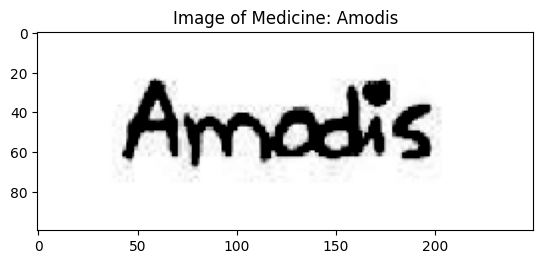

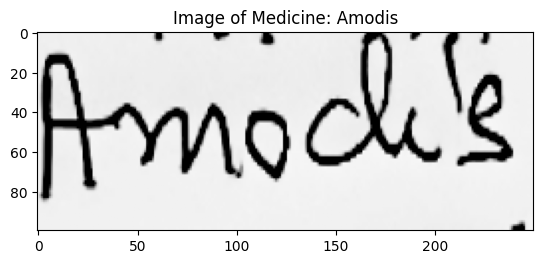

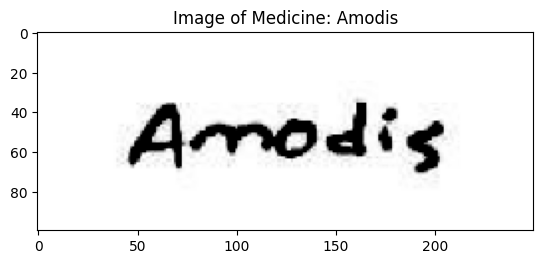

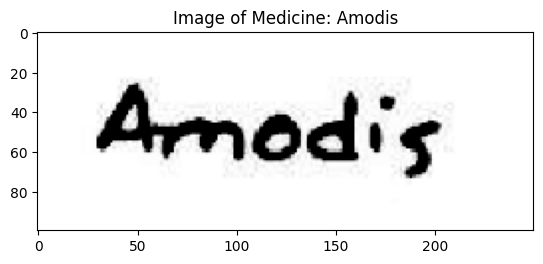

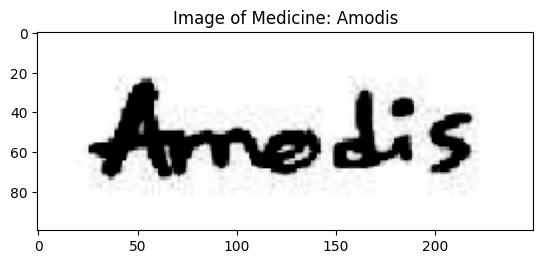

In [11]:
# Helper function to visualize images
def plot_img(x,y):
  plt.imshow(x)
  plt.title(f'Image of Medicine: {y}')
  plt.show()

for i in range(5):
  # plot_img(training_images[38+i], uniques_train[train_labels[38+i]])
  # plot_img(test_images[60+i], uniques_test[test_labels[60+i]])
  plot_img(val_images[30+i], uniques_val[val_labels[30+i]])

##1.2 Network Design
Convolutional neural networks are often appropriate for image processing tasks. The early
layers of the network consist of small convolutional filters which act like local feature detectors;
the later layers of the network aggregate the local feature responses into a global prediction.


A convolutional layer is parameterized by a filter matrix W and a bias vector b:


𝑧 = 𝜎(𝑊 ∗ 𝑥 + 𝑏)


where * indicates the convolution operation. The filter "slides" over the input image x and performs a dot product over a local window at each pixel in the image.


You will build a LeNet model which uses 5x5 convolutional filters and max pooling to downsample and aggregate filter responses.


We will modify the original design by adding an additional two-dimensional hidden layer before the final linear classifier to aid in visualizing the representation learned by the network.


The model should have the following architecture:
1. 2D convolution with 50 5x5 filters, 'valid' padding, ReLU activation
2. 2D max pooling with 2x2 window, stride of 2
3. 2D convolution with 20 5x5 filters, 'valid' padding, ReLU activation
4. 2D max pooling with 2x2 window, stride of 2
5. Flatten
6. Fully connected layer with 200 units, ReLU activation
7. Fully connected layer with 2 units, linear activation ("embedding" layer for visualization)
8. Fully connected layer with 10 units, softmax activation (output layer).


Compile the model to use the sparse categorical cross-entropy loss and the SGD optimizer with a learning rate of 0.01. Use a batch size of 100 over at least 20 epochs with a validation split of 0.1 during training. Feel free to tweak these parameters as you see fit.


Show the loss and accuracy curves you got with your best performing configuration. Evaluate your model on the training and test sets and describe its performance in terms of accuracy and overfitting.

In [12]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Save Checkpoint paths
lightweight_ckpt = '/tmp/ckpt/lightweight_best.model.keras'
lightweight_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=lightweight_ckpt,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr = 0.01
batch_size = 50
epochs = 100

inputs = Input(shape=(100, 250, 3),name='input_layer')  # Input layer: 4-dimensional vector
hidden = inputs
hidden_layers = []

hidden = layers.RandomZoom(0.2)(hidden)
hidden = layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))(hidden)
hidden = layers.RandomRotation(0.01)(hidden)

hidden = layers.Conv2D(50, 3, activation='leaky_relu', padding='same', name='conv1')(hidden)
hidden = layers.MaxPooling2D(pool_size=(3,3), strides=2)(hidden)
# hidden = Dropout(0.05)(hidden)

hidden = layers.Conv2D(80, 3, activation='leaky_relu', padding='same', name='conv12')(hidden)
hidden = layers.MaxPooling2D(pool_size=(3,3), strides=2)(hidden)
hidden = Dropout(0.01)(hidden)

hidden = layers.Conv2D(100, 3, activation='leaky_relu', padding='same', name='conv2')(hidden)
hidden = layers.MaxPooling2D(pool_size=(3,3), strides=2)(hidden)
hidden = Dropout(0.05)(hidden)

hidden = layers.Conv2D(200, 3, activation='leaky_relu', padding='same', name='conv3')(hidden)
hidden = layers.MaxPooling2D(pool_size=(2,2), strides=2)(hidden)
hidden = Dropout(0.05)(hidden)

hidden = layers.Flatten()(hidden)
hidden = layers.Dense(128, activation='leaky_relu', name='dense1')(hidden)
hidden = Dropout(0.05)(hidden)

embedding = layers.Dense(128, activation=None, name='embedding_for_vis')(hidden)
hidden_layers.append(embedding)
outputs = layers.Dense(78,activation='softmax',name='output')(embedding)

model = Model(inputs=inputs,outputs=outputs) # Model for end-to-end training
encoders = []
for l in hidden_layers:
  encoders.append(Model(inputs=inputs,outputs=l))

opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                    verbose=True,
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
                    callbacks=[lightweight_model_checkpoint_callback])

# Load the best model
model = keras.models.load_model(lightweight_ckpt)

print(model.summary())

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.0172 - loss: 4.3623 - val_accuracy: 0.0179 - val_loss: 4.3510
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.0115 - loss: 4.3576 - val_accuracy: 0.0218 - val_loss: 4.3448
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.0179 - loss: 4.3478 - val_accuracy: 0.0321 - val_loss: 4.3357
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.0218 - loss: 4.3426 - val_accuracy: 0.0256 - val_loss: 4.3192
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.0189 - loss: 4.3260 - val_accuracy: 0.0564 - val_loss: 4.2876
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.0262 - loss: 4.3038 - val_accuracy: 0.0500 - val_loss: 4.2183
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.0299 - loss: 4.2592 - val_accuracy: 0.0462 - val_loss: 4.1405
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.0445 - loss: 4.2084 - val_accu

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 100, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 100, 250, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 100, 250, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 100, 250, 50)   │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 124, 50)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv12 (Conv2D)                 │ (None, 49, 124, 80)    │        36,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 61, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 61, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 24, 61, 100)    │        72,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 30, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 30, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 11, 30, 200)    │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 15, 200)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 15, 200)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     1,920,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_for_vis (Dense)       │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 78)             │        10,062 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,236,484 (8.53 MB)

 Trainable params: 2,236,482 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


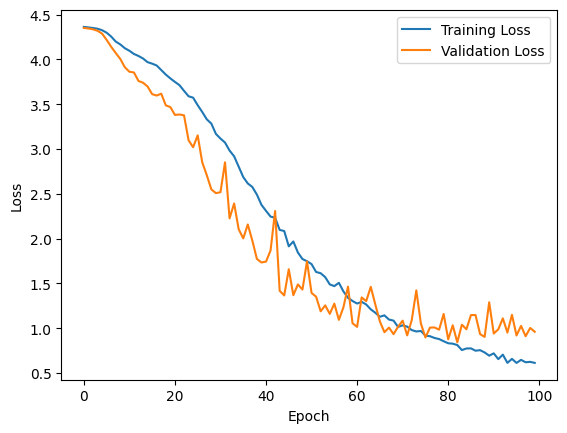

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [14]:
results = model.evaluate(test_images, test_labels,
                       verbose=False)
print('Final accuracy with TEST images and labels: ',results[1]*100)

Final accuracy with TEST images and labels:  74.35897588729858


In [15]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)
predictions

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


array([ 0,  0,  0,  9,  0,  0,  0,  0,  0,  9,  1, 45,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  4, 68,  2,  2, 60,  2, 68,  9, 68,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  1,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11, 10,
       10, 10, 10, 10, 10, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 29, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 71, 12,  1, 14, 54, 12,  2, 22, 22, 15, 68, 15,
       15, 15, 47, 15, 15, 15, 15, 20, 16,  5, 16, 16, 16, 16, 20, 16, 16,
       17, 34, 21, 17, 17, 34, 17, 17, 17, 34, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20,  9,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21,  9, 22,
       22, 22, 22, 22, 22

In [16]:
incorrect_class_count = 0
for i in range(len(predictions)):
  if predictions[i] != test_labels[i]:
    print(i, predictions[i], test_labels[i])
    incorrect_class_count += 1
print(incorrect_class_count)


3 9 0
9 9 0
11 45 1
21 4 2
22 68 2
25 60 2
27 68 2
28 9 2
29 68 2
80 1 8
100 11 10
107 11 10
108 11 10
120 11 12
129 29 12
141 71 14
142 12 14
143 1 14
145 54 14
146 12 14
147 2 14
148 22 14
149 22 14
151 68 15
155 47 15
160 20 16
162 5 16
167 20 16
171 34 17
172 21 17
175 34 17
179 34 17
203 9 20
219 9 21
231 33 23
234 34 23
235 16 23
237 24 23
239 24 23
249 13 24
251 57 25
252 26 25
253 26 25
256 26 25
257 26 25
258 71 25
259 28 25
261 34 26
262 24 26
263 19 26
264 71 26
265 31 26
267 15 26
268 71 26
269 47 26
278 77 27
281 37 28
285 57 28
287 57 28
291 31 29
292 17 29
295 5 29
296 17 29
297 54 29
298 31 29
299 16 29
301 29 30
304 32 30
305 63 30
315 64 31
316 58 31
321 34 32
322 66 32
324 37 32
327 34 32
328 34 32
329 27 32
336 31 33
337 32 33
338 17 33
345 32 34
349 72 34
351 29 35
355 71 35
356 2 35
357 67 35
358 4 35
359 18 35
361 18 36
365 14 36
368 11 36
369 4 36
373 18 37
406 39 40
408 38 40
417 9 41
429 22 42
446 64 44
448 43 44
451 55 45
458 32 45
459 50 45
461 6 46
465 13 4

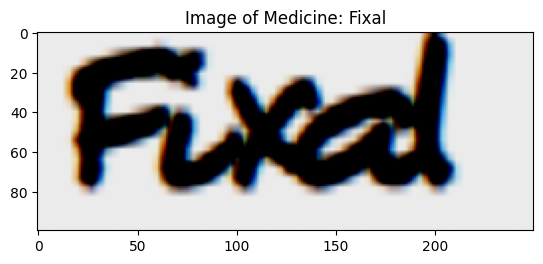

In [17]:
plot_img(test_images[330], uniques_test[test_labels[330]])

In [18]:
uniques_test[predictions[330]]

'Fixal'

ValueError: The number of FixedLocator locations (78), usually from a call to set_ticks, does not match the number of labels (2).

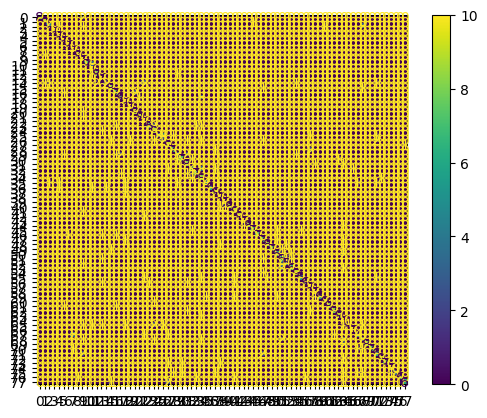

In [20]:
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

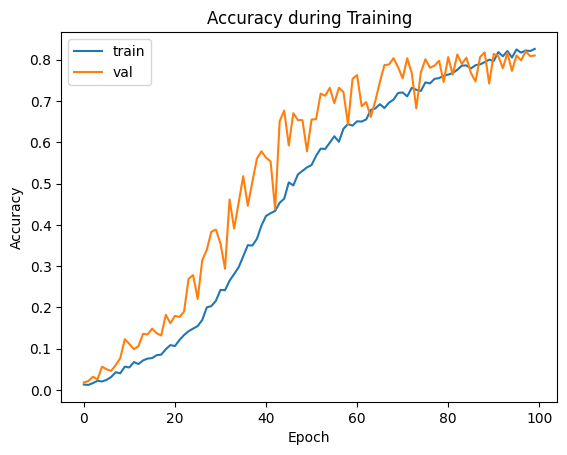

In [21]:
def plot_history(history):
  plt.plot(history.history['accuracy'],label='train')
  if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'],label='val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy during Training')
  plt.show()

plot_history(history)

# RESNET 50

In [22]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

# # CUSTOM F1  ########################################################################
# class F1Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.precision = tf.keras.metrics.Precision()
#         self.recall = tf.keras.metrics.Recall()

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred_labels = tf.argmax(y_pred, axis=1)
#         y_true = tf.reshape(y_true, [-1])
#         self.precision.update_state(y_true, y_pred_labels, sample_weight)
#         self.recall.update_state(y_true, y_pred_labels, sample_weight)

#     def result(self):
#         p = self.precision.result()
#         r = self.recall.result()
#         return 2 * ((p * r) / (p + r + K.epsilon()))

#     def reset_states(self):
#         self.precision.reset_states()
#         self.recall.reset_states()
# # CUSTOM F1  ########################################################################

# Data augmentation block
data_augmentation = models.Sequential([
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomRotation(0.01),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
], name="data_augmentation")

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(100, 250, 3))
base_model.trainable = False  # Freeze pretrained layers


model = models.Sequential([
    # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dropout(0.05),
    layers.Dense(78, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  # Tune this
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [24]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Save Checkpoint paths
head_ckpt = '/tmp/ckpt/head_best.model.keras'
head_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=head_ckpt,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

EPOCH_NUM = 100
# Train Classifier
history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=EPOCH_NUM,
                    validation_data=(val_images, val_labels),
                    verbose=True,
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
                    callbacks=[head_model_checkpoint_callback])

# Load the best model
model = keras.models.load_model(head_ckpt)





# Save Checkpoint paths
finetune_ckpt = '/tmp/ckpt/finetuned_best.model.keras'
finetune_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=finetune_ckpt,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Fine-tune Deeper Layer
model.layers[0].trainable = True
for layer in model.layers[0].layers[:-35]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  # Tune this
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=EPOCH_NUM,
          validation_data=(val_images, val_labels),
          verbose=True,
          # callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
          callbacks=[finetune_model_checkpoint_callback])

# Load the best model
model = keras.models.load_model(finetune_ckpt)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.3249 - loss: 3.0306 - val_accuracy: 0.3487 - val_loss: 2.9665
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3329 - loss: 2.9942 - val_accuracy: 0.3462 - val_loss: 2.9581
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.3345 - loss: 2.9716 - val_accuracy: 0.3628 - val_loss: 2.9225
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.3389 - loss: 2.9523 - val_accuracy: 0.3718 - val_loss: 2.9073
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.3658 - loss: 2.9013 - val_accuracy: 0.3795 - val_loss: 2.8774
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.3689 - loss: 2.8447 - val_accuracy: 0.3756 - val_loss: 2.8762
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.3516 - loss: 2.8610 - val_accuracy: 0.3628 - val_loss: 2.8537
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.3626 - loss: 2.8633 - val_accur

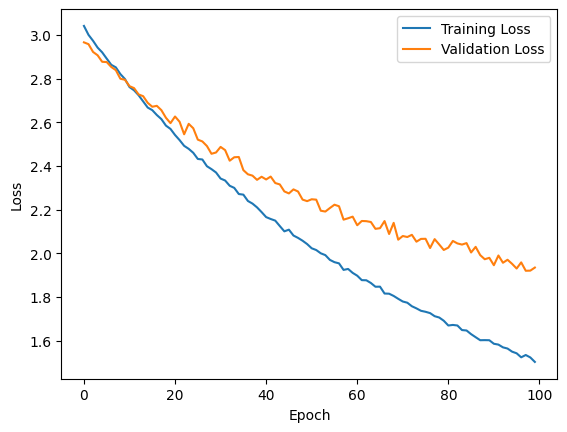

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

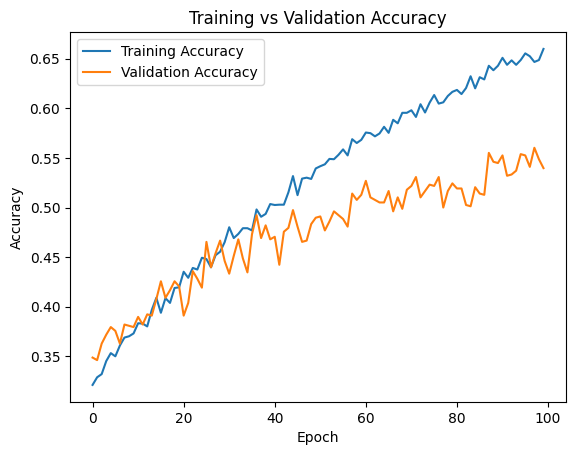

In [26]:
# Plot training and validation accuracy from the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [27]:
results = model.evaluate(test_images, test_labels,
                       verbose=False)
# for name, value in zip(model.metrics_names, results):
#     print(f"{name}: {value:.4f}")
print('Final accuracy with TEST images and labels: ',results[1]*100)

Final accuracy with TEST images and labels:  61.538463830947876


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)
y_pred = predictions
y_true = test_labels

precision = precision_score(y_true, y_pred, average='macro')  # or 'weighted' or 'micro'
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step
Precision: 0.65228
Recall:    0.61538
F1 Score:  0.60211
